In [1]:
using Pkg
Pkg.activate("..")
Pkg.instantiate()
Pkg.update()
# Pkg.upgrade_manifest()

  Activating project at `~/CropModeling/Garcumber`


    Updating registry at `~/.julia/registries/General.toml`


  No Changes to `~/CropModeling/Garcumber/Project.toml`
  No Changes to `~/CropModeling/Garcumber/Manifest.toml`


In [2]:
using Cropbox
using Test
# using Plots
using TimeZones
using DataFramesMeta
using CSV
# Cropbox.Interact.WebIO.setup(:ijulia)

In [3]:
obs_veget_1st = CSV.read("$(@__DIR__)/../data/Phenology_Vegetative_1st.csv", DataFrame) |> unitfy;
obs_repro_1st = CSV.read("$(@__DIR__)/../data/Phenology_Reproductive_1st.csv", DataFrame) |> unitfy;
obs_photo_1st = CSV.read("$(@__DIR__)/../data/Physiology_Photo_1st.csv", DataFrame) |> unitfy;
obs_lai_1st = CSV.read("$(@__DIR__)/../data/Morphology_LAI_1st.csv", DataFrame) |> unitfy;

In [4]:
obs_veget_2nd = CSV.read("$(@__DIR__)/../data/Phenology_Vegetative_2nd.csv", DataFrame) |> unitfy;
obs_repro_2nd = CSV.read("$(@__DIR__)/../data/Phenology_Reproductive_2nd.csv", DataFrame) |> unitfy;
obs_lai_2nd = CSV.read("$(@__DIR__)/../data/Morphology_LAI_2nd.csv", DataFrame) |> unitfy;
obs_fruitweightest_2nd = CSV.read("$(@__DIR__)/../data/Morphology_FruitWeightEst_2nd.csv", DataFrame) |> unitfy;

In [5]:
include("../src/Garlic.jl")

import Dates

In [6]:
# Cropbox.dependency(Garlic.Model)

In [7]:
tz = tz"Asia/Seoul"

Cucumber = @config (
    :Phenology => (
        optimal_temperature = 25, # Topt
        ceiling_temperature = 30, # Tceil
        critical_photoperiod = 12, # critPPD
        # initial_leaves_at_harvest = 5, # ILN
        maximum_leaf_initiation_rate = 1.70878, # LIR
        maximum_emergence_rate = 0.2,
        # maximum_leaf_initiation_rate = 0.1003, # LIR
        maximum_phyllochron_asymptote = 1.75561, # LTARa
        leaves_generic = 50, # GLN
    ),
    :Leaf => (
        maximum_elongation_rate = 4.70, # LER
        minimum_length_of_longest_leaf = 15.0, # LL
        # stay_green = 1.84, # SG
        stay_green = 20,
        length_to_width_ratio = 1,
        leaf_detaching_rate = 22, #LDR
    ),
    :Carbon => (
        maintenance_respiration_coefficient = 0.012, # Rm
        synthesis_efficiency = 0.8, # Yg
    ),
    :Meta => (; cultivar = :Cucumber),
    :Plant => (initial_planting_density = 20,),
);

In [8]:
Validate = @config(Cucumber, (
    :Phenology => (
        planting_date = ZonedDateTime(2020, 10, 22, tz"Asia/Seoul"),
        emergence_date = ZonedDateTime(2020, 10, 23, tz"Asia/Seoul"),
        # first_flowering_date = ZonedDateTime(2020, 11, 19, tz"Asia/Seoul"),
        first_flowering_date = ZonedDateTime(2020, 11, 10, tz"Asia/Seoul"),
    ),
    :Meta => (
        planting_group = 1,
        year = 2020,
    ),
    :Calendar => (
        init = ZonedDateTime(2020, 10, 22, tz"Asia/Seoul"),
        last = ZonedDateTime(2021, 2, 15, tz"Asia/Seoul"),
    ),
    :Weather => (
        CO2 = 400, # CO2 Enrichment
        store = Garlic.loadwea("$(@__DIR__)/../data/Cucumber1st.wea", tz"Asia/Seoul"),
    ),
));


In [9]:
Calibrate = @config(Cucumber, (
    :Phenology => (
        planting_date = ZonedDateTime(2021, 2, 1, tz"Asia/Seoul"), # Y1 sow
        emergence_date = ZonedDateTime(2021, 2, 23, tz"Asia/Seoul"), # Y1 emg
        first_flowering_date = ZonedDateTime(2021, 3, 24, tz"Asia/Seoul"),
    ),
    :Meta => (
        planting_group = 2,
        year = 2021,
    ),
    :Calendar => (
        init = ZonedDateTime(2021, 2, 1, tz"Asia/Seoul"),
        last = ZonedDateTime(2021, 8, 29, tz"Asia/Seoul"),
    ),
    :Weather => (
        CO2 = 500, # CO2 Enrichment
        store = Garlic.loadwea("$(@__DIR__)/../data/Cucumber2nd.wea", tz"Asia/Seoul"),
    ),
));

Progress:   1%[>                          ]  ETA: 0:14:05 ( 0.17  s/it)

Progress:   1%[>                          ]  ETA: 0:10:54 ( 0.13  s/it)

Progress:  20%[=====>                     ]  ETA: 0:00:43 (10.56 ms/it)

Progress:  35%[=========>                 ]  ETA: 0:00:22 ( 6.63 ms/it)

Progress:  48%[============>              ]  ETA: 0:00:14 ( 5.30 ms/it)

Progress:  60%[================>          ]  ETA: 0:00:09 ( 4.64 ms/it)

Progress:  70%[==================>        ]  ETA: 0:00:06 ( 4.27 ms/it)

Progress:  79%[=====================>     ]  ETA: 0:00:04 ( 4.03 ms/it)

Progress:  88%[=======================>   ]  ETA: 0:00:02 ( 3.88 ms/it)

Progress:  96%[=========================> ]  ETA: 0:00:01 ( 3.77 ms/it)

Progress: 100%[===========================] Time: 0:00:18 ( 3.73 ms/it)


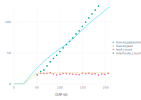

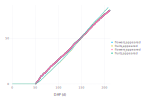

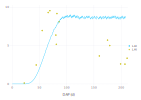

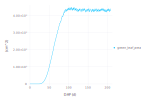

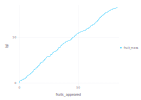

In [10]:
cali = simulate(Garlic.Model;
    config=Calibrate,
    stop="calendar.count",
    snap=s -> Dates.hour(s.calendar.time') == 12,
)
# @test r.leaves_initiated[end] > 0

plot_veg = visualize(cali, :DAP, [:leaves_appeared, :leaves_real], kind=:line)
visualize!(plot_veg, obs_veget_2nd, :DAP, [:leaf_count, :internode_count]) |> display # Fig. 3.D
plot_rep = visualize(cali, :DAP, [:flowers_appeared, :fruits_appeared], kind=:line)
visualize!(plot_rep, obs_repro_2nd, :DAP, [:flowers_appeared, :fruits_appeared]) |> display
plot_lai = visualize(cali, :DAP, :LAI, kind=:line)
visualize!(plot_lai, obs_lai_2nd, :DAP, [:LAI]) |> display # Fig. 4.D
visualize(cali, :DAP, :green_leaf_area, kind=:line) |> display
# visualize(r, :DAP, [:leaf_mass, :total_mass, :fruit_mass]) |> display
# plot_photo = visualize(r, :DAP, [:A_net], kind=:line)
# visualize!(plot_photo, obs_photo_2nd, :DAP, [:photo_a]) |> display
# p = visualize(r, :DAP, [:leaves_real], kind=:line)
visualize(cali, :fruits_appeared, [:fruit_mass], kind=:line) |> display

Progress:  29%[=======>                   ]  ETA: 0:00:03 ( 1.38 ms/it)

Progress:  55%[==============>            ]  ETA: 0:00:02 ( 1.42 ms/it)

Progress:  80%[=====================>     ]  ETA: 0:00:01 ( 1.50 ms/it)

Progress: 100%[===========================] Time: 0:00:04 ( 1.56 ms/it)


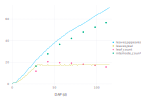

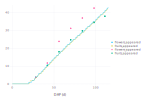

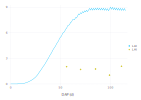

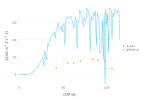

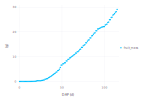

In [11]:
r = simulate(Garlic.Model;
    config=Validate,
    stop="calendar.count",
    snap=s -> Dates.hour(s.calendar.time') == 12,
)
# @test r.leaves_initiated[end] > 0

plot_veg = visualize(r, :DAP, [:leaves_appeared, :leaves_real], kind=:line)
visualize!(plot_veg, obs_veget_1st, :DAP, [:leaf_count, :internode_count]) |> display # Fig. 3.D
plot_rep_fl = visualize(r, :DAP, [:flowers_appeared, :fruits_appeared], kind=:line)
visualize!(plot_rep_fl, obs_repro_1st, :DAP, [:flowers_appeared, :fruits_appeared]) |> display

plot_lai = visualize(r, :DAP, :LAI, kind=:line)
visualize!(plot_lai, obs_lai_1st, :DAP, [:LAI]) |> display # Fig. 4.D

plot_photo = visualize(r, :DAP, [:A_net], kind=:line)
visualize!(plot_photo, obs_photo_1st, :DAP, [:photo_a]) |> display

visualize(r, :DAP, [:fruit_mass]) |> display

In [12]:
# f(s) = s.DAP' in obs_repro_2nd.DAP && Dates.hour(s.calendar.time') == 12

# calibrate(Garlic.Model, obs_repro_2nd;
#     config=Calibrate,
#     stop="calendar.count",
#     index=:DAP,
#     target=:flowers_appeared => :flowers_appeared,
#     parameters= :Phenology => (;
#         FAR_max = (0.4, 1.8),
#         FIR_max = (0.4, 1.8),
#     ),
#     snap=f,
#     optim=(:MaxSteps => 20,),
# )

# calibrate(Garlic.Model, obs_repro_2nd;
#     config=Calibrate,
#     stop="calendar.count",
#     index=:DAP,
#     target=:fruits_appeared => :fruits_appeared,
#     parameters= :Phenology => (;
#         FRIR_max = (0.4, 1.8),
#         FRAR_max = (0.4, 1.8),
#     ),
#     snap=f,
#     optim=(:MaxSteps => 20,),
# )

In [13]:
# f(s) = s.DAP' in obs_veget_2nd.DAP && Dates.hour(s.calendar.time') == 12

# calibrate(Garlic.Model, obs_veget_2nd;
#     config=Calibrate,
#     stop="calendar.count",
#     index=:DAP,
#     target=:internode_count => :leaves_appeared,
#     parameters= :Phenology => (;
#         LTARa_max = (0.4, 1.8),
#         LIR_max = (0.4, 1.8),
#     ),
#     snap=f,
#     optim=(:MaxSteps => 50,),
# )

In [14]:
evaluate(Garlic.Model, obs_veget_2nd; 
    config = Calibrate,
    index = :DAP => :DAP,
    stop="calendar.count",
    snap=s -> Dates.hour(s.calendar.time') == 12,
    target = (
        :leaf_count => :leaves_real,
        :internode_count => :leaves_appeared,
    ),
    metric = :ef) |> display

evaluate(Garlic.Model, obs_veget_2nd; 
    config = Calibrate,
    index = :DAP => :DAP,
    stop="calendar.count",
    snap=s -> Dates.hour(s.calendar.time') == 12,
    target = (
        :leaf_count => :leaves_real,
        :internode_count => :leaves_appeared,
    ),
    metric = :rmse) |> display

evaluate(Garlic.Model, obs_repro_2nd; 
    config = Calibrate,
    index = :DAP => :DAP,
    stop="calendar.count",
    snap=s -> Dates.hour(s.calendar.time') == 12,
    target = (
        :flowers_appeared => :flowers_appeared,
        :fruits_appeared => :fruits_appeared,
    ),
    metric = (:ef)) |> display

evaluate(Garlic.Model, obs_repro_2nd; 
    config = Calibrate,
    index = :DAP => :DAP,
    stop="calendar.count",
    snap=s -> Dates.hour(s.calendar.time') == 12,
    target = (
        :flowers_appeared => :flowers_appeared,
        :fruits_appeared => :fruits_appeared,
    ),
    metric = (:rmse)) |> display

(-3.7552598723024753, 0.9308031392572956)

(1.9434019417039907, 10.285985781581108)

(0.9827863650109431, 0.9825041623820099)

(2.962333431493246, 2.9996014134833415)

In [15]:
evaluate(Garlic.Model, obs_veget_1st; 
    config = Validate,
    index = :DAP => :DAP,
    stop="calendar.count",
    snap=s -> Dates.hour(s.calendar.time') == 12,
    target = (
        :leaf_count => :leaves_real,
        :internode_count => :leaves_appeared,
    ),
    metric = :ef) |> display

evaluate(Garlic.Model, obs_veget_1st; 
    config = Validate,
    index = :DAP => :DAP,
    stop="calendar.count",
    snap=s -> Dates.hour(s.calendar.time') == 12,
    target = (
        :leaf_count => :leaves_real,
        :internode_count => :leaves_appeared,
    ),
    metric = :rmse) |> display

evaluate(Garlic.Model, obs_repro_1st; 
    config = Validate,
    index = :DAP => :DAP,
    stop="calendar.count",
    snap=s -> Dates.hour(s.calendar.time') == 12,
    target = (
        :flowers_appeared => :flowers_appeared,
        :fruits_appeared => :fruits_appeared,
    ),
    metric = (:ef)) |> display

evaluate(Garlic.Model, obs_repro_1st; 
    config = Validate,
    index = :DAP => :DAP,
    stop="calendar.count",
    snap=s -> Dates.hour(s.calendar.time') == 12,
    target = (
        :flowers_appeared => :flowers_appeared,
        :fruits_appeared => :fruits_appeared,
    ),
    metric = (:rmse)) |> display


(0.10554533508541386, 0.6177077337955028)

(2.6354723079012397, 8.145770155643445)

(0.8271001468089528, 0.9898324220781692)

(6.1046235405165294, 1.1791340648362014)

In [16]:
cali = Cropbox.deunitfy(cali)
r = Cropbox.deunitfy(r)

CSV.write("$(@__DIR__)/../data/Model_Output(Calibrate).csv", cali)
CSV.write("$(@__DIR__)/../data/Model_Output.csv(Validate).csv", r)

"/home/cariso27001/CropModeling/Garcumber/test/../data/Model_Output.csv(Validate)"

In [17]:
# manipulate(Garlic.Model, :DAP, [:leaves_appeared, :leaves_mature, :leaves_dropped, :leaves_detached, :leaves_real];
#     config = Cucumber,
#     parameters = :Phenology => (;
#         optimal_temperature = 10:40,
        
#     ),
#     stop = "calendar.count",
#     kind = :line,
# )